## Assignment 7 
### Feature selection

In this assignment, the HTRU2 dataset is used that can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HTRU2).

In this workbook, feature selection techniques are implemented.
To minimize the work, all models that are trained in this workbook are XGBoost classifier. No other combinations of features/models are tested to find the best scoring one. Also, with every feature selection technique the dimensionality of the predictor variables is reduced to half (4 features selected). Last, a model is trained will all features and the results are compared.

### Introduction
Introduction can be found on asgmt7_feat_importance_afoudouli.ipynb

In [19]:
# if needed install packages uncommenting the following commands
#!pip install mlxtend

In [35]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os 

os.chdir('C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt7_FeatureSelection/')

In [2]:
data_file = 'HTRU2/HTRU_2.csv'

data = pd.read_csv(data_file, header=None)


feature_names = ["Mean of the integrated profile",
	"Standard deviation of the integrated profile",
	"Excess kurtosis of the integrated profile",
	"Skewness of the integrated profile",
	"Mean of the DM-SNR curve",
	"Standard deviation of the DM-SNR curve",
	"Excess kurtosis of the DM-SNR curve",
	"Skewness of the DM-SNR curve"]

data.columns = feature_names + ["target_class"]

In [5]:
# split in train-test set in a stratified manner
X = data.drop(columns = 'target_class')
y = data['target_class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=556, stratify=y)

In [6]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

** Feature Selection **
As the name suggests, feature selection is the process of selecting the most _significant_ and_relevant_ features from a vast set of features in the given dataset. It is a crusial component in ML and data science workflows, especially when dealing with high-dimensional data.  
Feature selections helps finding the smallest set of features, thus resulting in: 
* training any ML algorithm faster
* reducing the complexity of a model, making it easier to interpret
* reducing over-fitting by selecting the right set of features

** Filter Method ** 
 
Statistical tests can be used to select those features that have the strongest relationship with the output variable.  
In this method, as the name suggests, we are filtering the dataset and select only a subset of the available features. The selection of features is independent of any machine learning algorithm. Features give rank on the basis of statistical scores which tend to determine the features' correlation with the outcome variable. Correlation is a heavily contextual term, and it varies from work to work.  
Example methods: Correlation coefficient scores (like Pearson's correlation), chi-squared test, information gain

In [17]:
test = SelectKBest(score_func=chi2, k=4)
X_filter = test.fit_transform(X_train, y_train)
print('Selected variables are positioned at:', test.get_support(indices=True))

Selected variables are positioned at: [2 3 4 5]


** Wrapper Methods ** 



In [21]:
sfs = SFS(XGBClassifier(),
          k_features=4,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X_train, y_train)
print('Selected variables using forward selection are at positions:', sfs.k_feature_names_)

Selected variables using forward selection are at positions: ('0', '2', '3', '6')


In [22]:
sfs = SFS(XGBClassifier(),
          k_features=4,
          forward=False,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X_train, y_train)
print('Selected variables using backward selection are at positions:', sfs.k_feature_names_)

Selected variables using backward selection are at positions: ('1', '2', '5', '6')


_We can use the same python code to find the optimal number of features and not directly specifying to keep only 4. The resulting model performance is ploted._

In [25]:
sfs = SFS(XGBClassifier(),
          k_features=(2,8),
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  

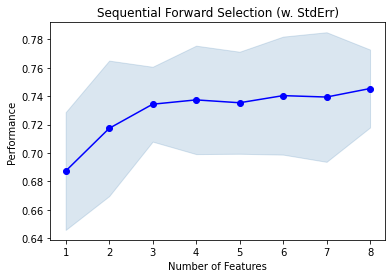

In [27]:
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)');

** Recursive feature elimination **

In [34]:
clf = XGBClassifier()

trans = RFE(clf, n_features_to_select=4)
X_rfe = trans.fit_transform(X_train, y_train)

print('Selected features using RFE are on positions:', [x for x,y in enumerate(trans.get_support()) if y])

Selected features using RFE are on positions: [0, 2, 5, 6]


In [40]:
clf = XGBClassifier()

trans = RFECV(clf, cv=5, n_jobs=-1, scoring='recall')
X_rfecv = trans.fit_transform(X_train, y_train)

print('Selected features using RFE are on positions:', [x for x,y in enumerate(trans.get_support()) if y])

Selected features using RFE are on positions: [0, 1, 2, 3, 4, 5, 6, 7]


In [41]:
trans.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1])